# Visualization of different values of discriminative need

## Configs

In [23]:
import os

import hydra
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

import torch
import pandas as pd
import plotnine as pn

import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")
from misc.util import get_curve_fn


## Initialize Hydra Config

In the cell below, use the `overrides` kwarg to pass in the specific things you want for plotting. You should essentially treat it like command line args you would pass to hydra.

In [24]:
overrides = [
    "game.num_states=50",
    "game.num_signals=5",

    "game.meaning_dist_gamma=0",

    # Only uncomment one of the following
    "simulation/dynamics=two_population_rd",
    # "simulation/dynamics=nowak_krakauer",

    "simulation.dynamics.imprecise_imitation_gamma=0",

    # Uncomment for non-default finite population evolution
    # "simulation/dynamics.population_size=100",

    "simulation.num_trials=8",
]

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

# Define a helper which lets us compose new configs since we can't use multirun
def compose(new_overrides):
    """Return a composed hydra config."""
    cfg = hydra.compose(
        config_name="config",
        overrides=overrides + new_overrides,
    )
    return cfg

### Load filepaths

In [25]:
# Filepaths

# user's path to root of repo
root_path = "/Users/nathanielimel/uci/projects/ibsg"
multirun_path = os.path.join(root_path, config.filepaths.hydra_sweep_root)

#############################################################################
# Analysis files
#############################################################################

curve_dir = os.path.join(multirun_path, config.filepaths.curve_subdir)
curve_fn = get_curve_fn(config, curve_dir=curve_dir)
mse_curve_fn = get_curve_fn(config, "mse", curve_dir=curve_dir)

#############################################################################
# Simulation points
#############################################################################

sim_sweep_subdir = os.path.join(multirun_path, config.filepaths.sim_sweep_subdir)

def get_sim_fn(discr_need: str) -> str:
    # to simulate a sweep, we can compose for each value swept
    cfg = compose([f"game.discriminative_need_gamma={discr_need}"])
    return os.path.join(multirun_path, cfg.filepaths.simulation_subdir, cfg.filepaths.simulation_points_save_fn)

get_discr_need = lambda dir: dir.split("=")[1]

sim_fns = {
    get_discr_need(dir): 
    get_sim_fn(get_discr_need(dir)) for dir in os.listdir(sim_sweep_subdir) if "=" in dir
}

sim_fns

{'0': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=50/signals=5/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_trials=8/seed=42/discr_need=0/simulation_points.csv',
 '1': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=50/signals=5/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_trials=8/seed=42/discr_need=1/simulation_points.csv',
 '-1': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=50/signals=5/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_trials=8/seed=42/discr_need=-1/simulation_points.csv',
 '-3': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=50/signals=5/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_trials=8/seed=42/discr_need=-3/simulation_points.csv',
 '3': '/Users/nathanielimel/uci/projects/ibsg/multirun/states=50

### Load data

In [26]:
# load dataframes
read = lambda fn: pd.read_csv(os.path.join(root_path, fn))
curve_data = read(curve_fn)
ub_curve_data = read(mse_curve_fn)

sim_dfs = {k: read(sim_fns[k]) for k in sim_fns}

## Configure aesthetics

In [27]:
# label each df to be concatenated with a columns
for key in sim_dfs:
    df = sim_dfs[key]
    df["discr_need"] = key


sim_data = pd.concat(sim_dfs.values())

In [28]:
sim_data["discr_need"] = sim_data["discr_need"].astype(float)
sim_data # N.B.: nans are expected for 'round' column

,complexity,accuracy,distortion,mse,trial,discr_need
0,2.284108,2.015027,2.110231,262.634033,0,0.0
1,2.307418,2.005040,2.120219,332.661316,1,0.0
2,2.184822,1.983013,2.142245,261.399994,2,0.0
3,2.153521,1.819910,2.305348,354.799988,3,0.0
4,1.947342,1.531819,2.593439,186.869334,4,0.0
5,1.370252,1.119335,3.005924,252.461649,5,0.0
6,1.427347,1.086970,3.038288,325.229990,6,0.0
7,1.525658,1.342765,2.782493,290.177226,7,0.0
0,2.313521,1.236320,2.888938,396.976257,0,1.0
1,2.319038,1.146944,2.978315,405.527313,1,1.0


## Plot

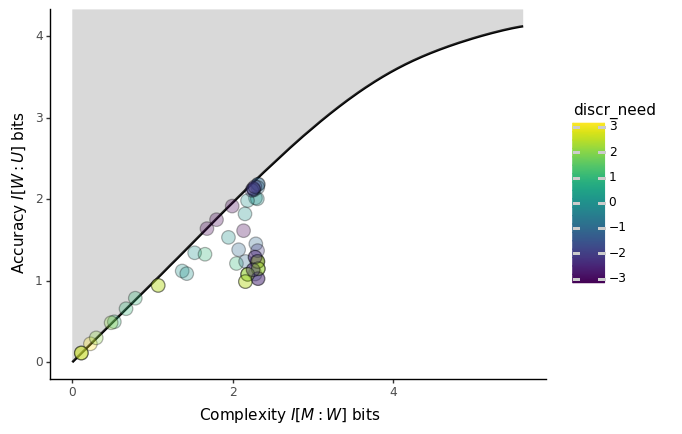

In [29]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

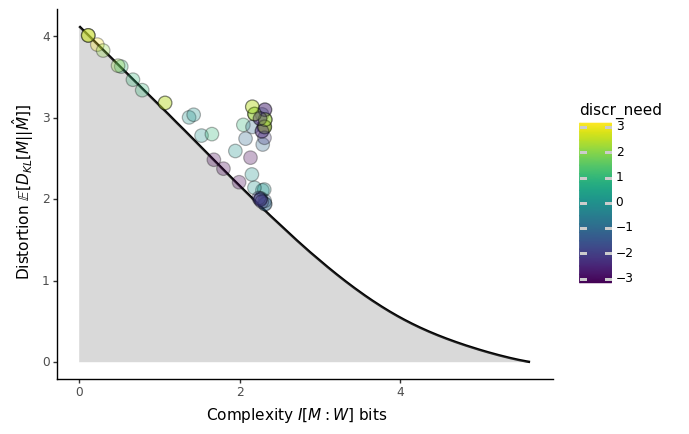

In [30]:
cc_plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="distortion")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin=0,
        ymax="distortion",
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Distortion $\mathbb{E}[D_{KL}[ M || \hat{M} ]]$")
    + pn.theme_classic()
)
print(cc_plot)

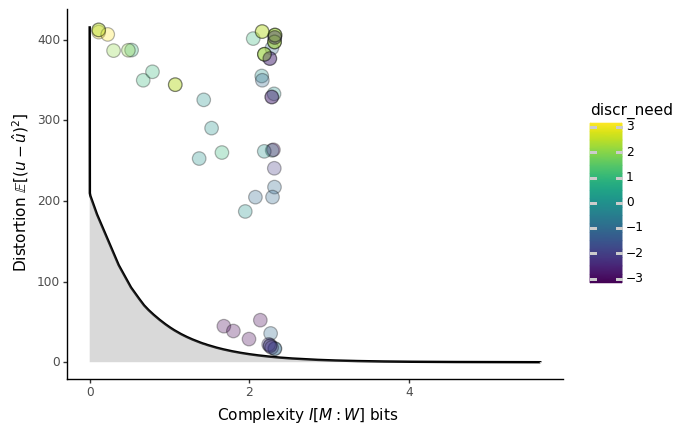

In [31]:
ub_plot = (
    # Set data and the axes
    pn.ggplot(
        data=ub_curve_data, mapping=pn.aes(x="complexity", y="mse")
    )  
    + pn.geom_line(size=1) # UB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin=0,
        ymax="mse",
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Distortion $\mathbb{E}[(u - \hat{u})^2]$")
    + pn.theme_classic()
)
print(ub_plot)

In [32]:
pd.set_option("display.max_rows", 64)
sim_data

,complexity,accuracy,distortion,mse,trial,discr_need
0,2.284108,2.015027,2.110231,262.634033,0,0.0
1,2.307418,2.005040,2.120219,332.661316,1,0.0
2,2.184822,1.983013,2.142245,261.399994,2,0.0
3,2.153521,1.819910,2.305348,354.799988,3,0.0
4,1.947342,1.531819,2.593439,186.869334,4,0.0
5,1.370252,1.119335,3.005924,252.461649,5,0.0
6,1.427347,1.086970,3.038288,325.229990,6,0.0
7,1.525658,1.342765,2.782493,290.177226,7,0.0
0,2.313521,1.236320,2.888938,396.976257,0,1.0
1,2.319038,1.146944,2.978315,405.527313,1,1.0


## Save plots

In [33]:
# save plots in folder above sweep over discriminative need
plot_dir = os.path.join(root_path, sim_sweep_subdir).replace("curve_points.csv", "")



plots = {
    "complexity_accuracy": plot,
    "complexity_distortion": cc_plot,
    "complexity_mse": ub_plot,
}


for fn in plots:
    plots[fn].save(os.path.join(plot_dir, fn), width=10, height=10, dpi=300,)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/uci/projects/ibsg/multirun/states=50/signals=5/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_trials=8/seed=42/complexity_accuracy
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/uci/projects/ibsg/multirun/states=50/signals=5/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=two_population_rd/ii=3/population_size=None/num_trials=8/seed=42/complexity_distortion
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-

Reset hydra in order to run all again